# LSTM track-finding model for 2D detector layers

In this notebook we extend the method of the "simple" LSTM on 1D detector layer data to 2D detector layers, using the data functionality developed in the DataGen2D notebook.

In [24]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Local imports
from metrics import calc_hit_accuracy

# Magic
%matplotlib notebook

In [26]:
# Set random seed
np.random.seed(2017)

## Utilities

In [2]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, figsize=(9.5, 4.5)):
    """Draw each detector layer as a grid of images"""
    num_det_layers = event.shape[0]
    nrows = math.ceil(float(num_det_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_det_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
    plt.tight_layout()

def draw_train_history(history, figsize=(9.5, 4.5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend()
    plt.tight_layout()

In [3]:
def gen_noise_2d(shape, prob=0.1, seed_layers=0):
    noise = (np.random.random_sample(shape) < prob).astype(np.int8)
    noise[:,:seed_layers,:,:] = 0
    return noise

def gen_straight_tracks_2d(n, num_det_layers, det_layer_size):
    # Initialize the data
    data = np.zeros((n, num_det_layers, det_layer_size, det_layer_size),
                    dtype=np.float32)
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_det_layers - 1)
    # Calculate hit positions and fill hit data
    xhits = np.zeros(num_det_layers, dtype=np.int)
    yhits = np.zeros(num_det_layers, dtype=np.int)
    idx = np.arange(num_det_layers)
    for ievt in range(n):
        xhits[:] = slopes[ievt,0]*idx + entry_points[ievt,0]
        yhits[:] = slopes[ievt,1]*idx + entry_points[ievt,1]
        data[ievt,idx,xhits,yhits] = 1   
    return data

def gen_bkg_tracks_2d(num_event, num_det_layers, det_layer_size,
                      avg_bkg_tracks=3, seed_layers=0):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_det_layers, det_layer_size, det_layer_size),
                          dtype=np.float32)
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks_2d(ntrk, num_det_layers, det_layer_size))
    bkg_tracks[:,:seed_layers,:,:] = 0
    return bkg_tracks

In [4]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

def flat_to_2d(data, det_width):
    """Expands the flattened layers to original (width x width)"""
    return data.reshape((data.shape[0], data.shape[1], det_width, det_width))

## Configuration

In [6]:
num_event = 51200
num_det_layers = 10
det_layer_size = 16
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
shape = (num_event, num_det_layers, det_layer_size, det_layer_size)
det_shape = shape[1:]

## Data generation

In [7]:
# Signal tracks
sig_tracks = gen_straight_tracks_2d(num_event, num_det_layers, det_layer_size)
# Background tracks
bkg_tracks = gen_bkg_tracks_2d(num_event, num_det_layers, det_layer_size,
                               avg_bkg_tracks=avg_bkg_tracks,
                               seed_layers=num_seed_layers)
# Noise
noise = gen_noise_2d(shape, prob=noise_prob, seed_layers=num_seed_layers)

# Full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

# Print data sizes
print('Sizes of arrays')
print('  events:     %g MB' % (events.dtype.itemsize * events.size / 1e6))
print('  sig_tracks: %g MB' % (sig_tracks.dtype.itemsize * sig_tracks.size / 1e6))
print('  bkg_tracks: %g MB' % (bkg_tracks.dtype.itemsize * bkg_tracks.size / 1e6))
print('  noise:      %g MB' % (noise.dtype.itemsize * noise.size / 1e6))

# Cleanup
del bkg_tracks
del noise

Sizes of arrays
  events:     524.288 MB
  sig_tracks: 524.288 MB
  bkg_tracks: 524.288 MB
  noise:      131.072 MB


<IPython.core.display.Javascript object>


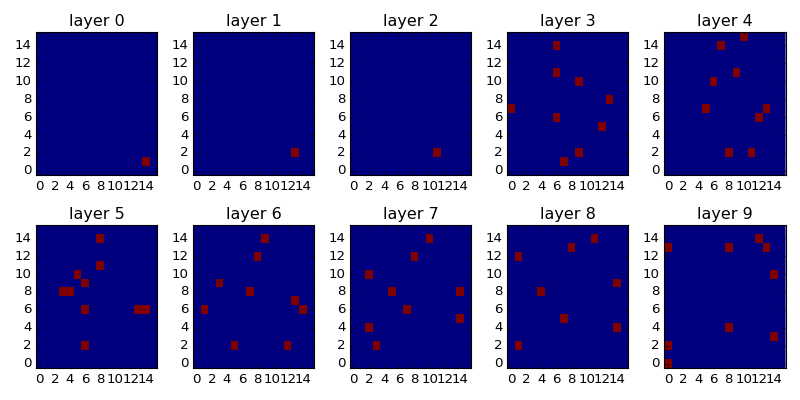

In [21]:
# Visualize one event
draw_layers(events[0], figsize=(10, 5))

## Define the model

In [9]:
def build_model(det_shape, num_hidden=100,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    # Output fully-connected layer
    outputs = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_deep_model(det_shape, num_hidden=100,
                     loss='categorical_crossentropy',
                     optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    # Input fully-connected layer
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='relu'))(inputs)
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(hidden)
    # Output fully-connected layers
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='relu'))(hidden)
    outputs = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Training

In [13]:
# Configure the training
num_hidden = 128
batch_size = 256
num_epoch = 10
valid_frac = 0.2

train_input = flatten_layers(events[:,:-1,:,:])
train_target = flatten_layers(sig_tracks[:,1:,:,:])

In [14]:
# Build the model
model = build_deep_model(det_shape, num_hidden=num_hidden)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 9, 256)        0                                            
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribute(None, 9, 128)        32896       input_2[0][0]                    
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 9, 128)        131584      timedistributed_4[0][0]          
____________________________________________________________________________________________________
timedistributed_5 (TimeDistribute(None, 9, 128)        16512       lstm_2[0][0]                     
___________________________________________________________________________________________

In [15]:
# Train the model
history = model.fit(train_input, train_target,
                    batch_size=batch_size, nb_epoch=num_epoch,
                    validation_split=valid_frac)

# Get all of the training data predictions
train_preds = model.predict(train_input, batch_size=batch_size)

Train on 40960 samples, validate on 10240 samples
Epoch 1/10
40960/40960 [==============================] - 17s - loss: 4.7421 - acc: 0.0338 - val_loss: 3.9545 - val_acc: 0.0695
Epoch 2/10
40960/40960 [==============================] - 17s - loss: 3.3890 - acc: 0.1100 - val_loss: 2.9735 - val_acc: 0.1492
Epoch 3/10
40960/40960 [==============================] - 17s - loss: 2.7758 - acc: 0.1714 - val_loss: 2.6294 - val_acc: 0.1915
Epoch 4/10
40960/40960 [==============================] - 17s - loss: 2.5184 - acc: 0.2083 - val_loss: 2.4550 - val_acc: 0.2177
Epoch 5/10
40960/40960 [==============================] - 17s - loss: 2.3694 - acc: 0.2318 - val_loss: 2.3715 - val_acc: 0.2302
Epoch 6/10
40960/40960 [==============================] - 17s - loss: 2.2711 - acc: 0.2505 - val_loss: 2.3386 - val_acc: 0.2408
Epoch 7/10
40960/40960 [==============================] - 17s - loss: 2.1994 - acc: 0.2647 - val_loss: 2.2756 - val_acc: 0.2506
Epoch 8/10
40960/40960 [==============================

<IPython.core.display.Javascript object>


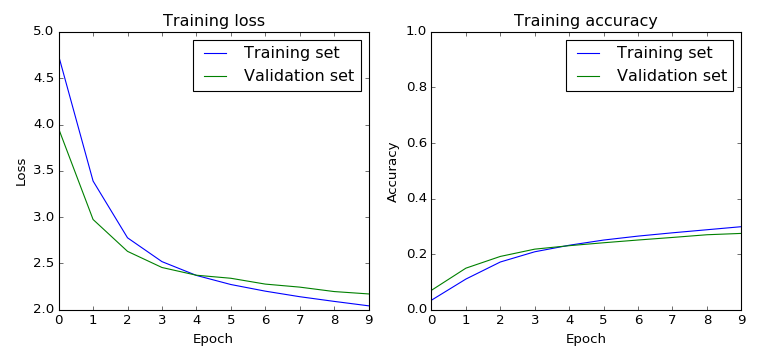

In [22]:
draw_train_history(history)

<IPython.core.display.Javascript object>


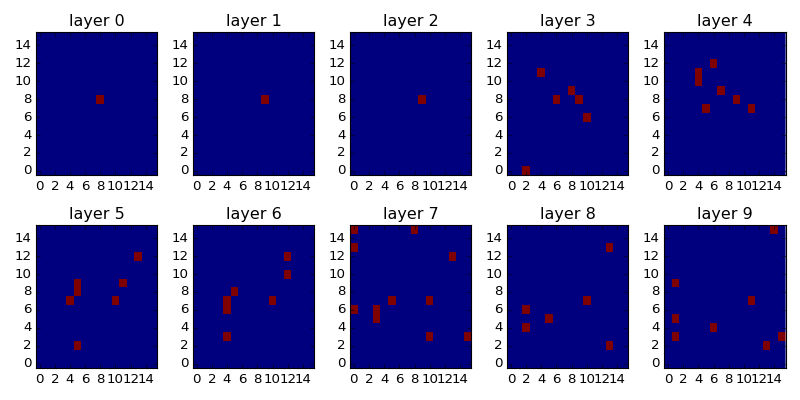

<IPython.core.display.Javascript object>


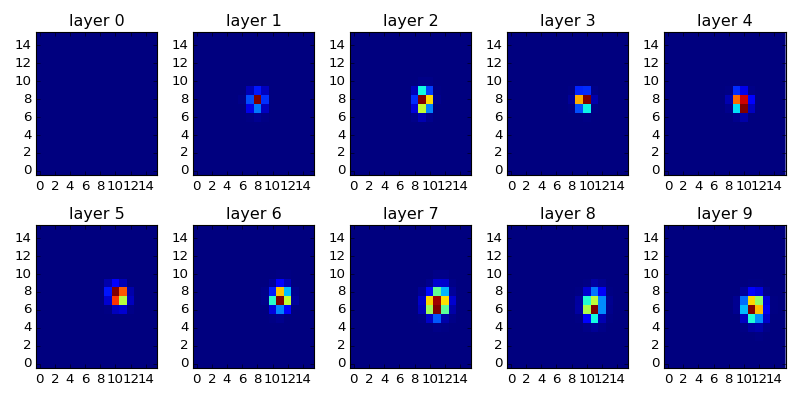

In [23]:
# Visualize one event
disp_idx = 6
draw_layers(events[disp_idx], figsize=(10, 5))

pred = np.zeros(det_shape)
pred[1:] = train_preds[disp_idx].reshape((num_det_layers-1, det_layer_size, det_layer_size))
draw_layers(pred, figsize=(10, 5))

In [15]:
calc_hit_accuracy(train_preds, train_target, num_seed_layers=num_seed_layers)

0.11763346354166666

In [16]:
# Now let's try to compute additional metrics, such as hit classification accuracy,
# whereby we only look at pixels that have a hit. To do this, we first multiply
# the prediction scores with the binary data.
scores = train_preds * flatten_layers(events[:,1:,:,:])
calc_hit_accuracy(scores, train_target)

0.89754340277777778